In [1]:
import torch
from super_gradients.training import models
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)
from super_gradients.training import Trainer


[2023-09-09 16:30:23] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/fer/sg_logs/console.log


/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-09 16:30:25] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-09 16:30:25] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-09 16:30:25] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-09 16:30:25] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# MODEL_ARCH = "yolo_nas_m"
# #            'yolo_nas_s'
# #            'yolo_nas_l'

# model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)
# CONFIDENCE_TRESHOLD = 0.35

# result = list(model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]

In [3]:
import os
HOME = os.getcwd()
print(HOME)

In [4]:
MODEL_ARCH = 'yolo_nas_m'
BATCH_SIZE = 8
CHECKPOINT_DIR = './checkpoints'
LOCATION = "../dataset/"
CLASSES = ['ball', 'goalkeeper', 'player', 'referee']
NUM_CLASES = len(CLASSES)
EXPERIMENT = "FUTSTATS"
EPOCHS = 600

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}



train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Caching annotations:   0%|          | 0/612 [00:00<?, ?it/s]

/home/fer/Escritorio/futstatistics/yolo_nas


Caching annotations: 100%|██████████| 38/38 [00:00<00:00, 6952.69it/s]


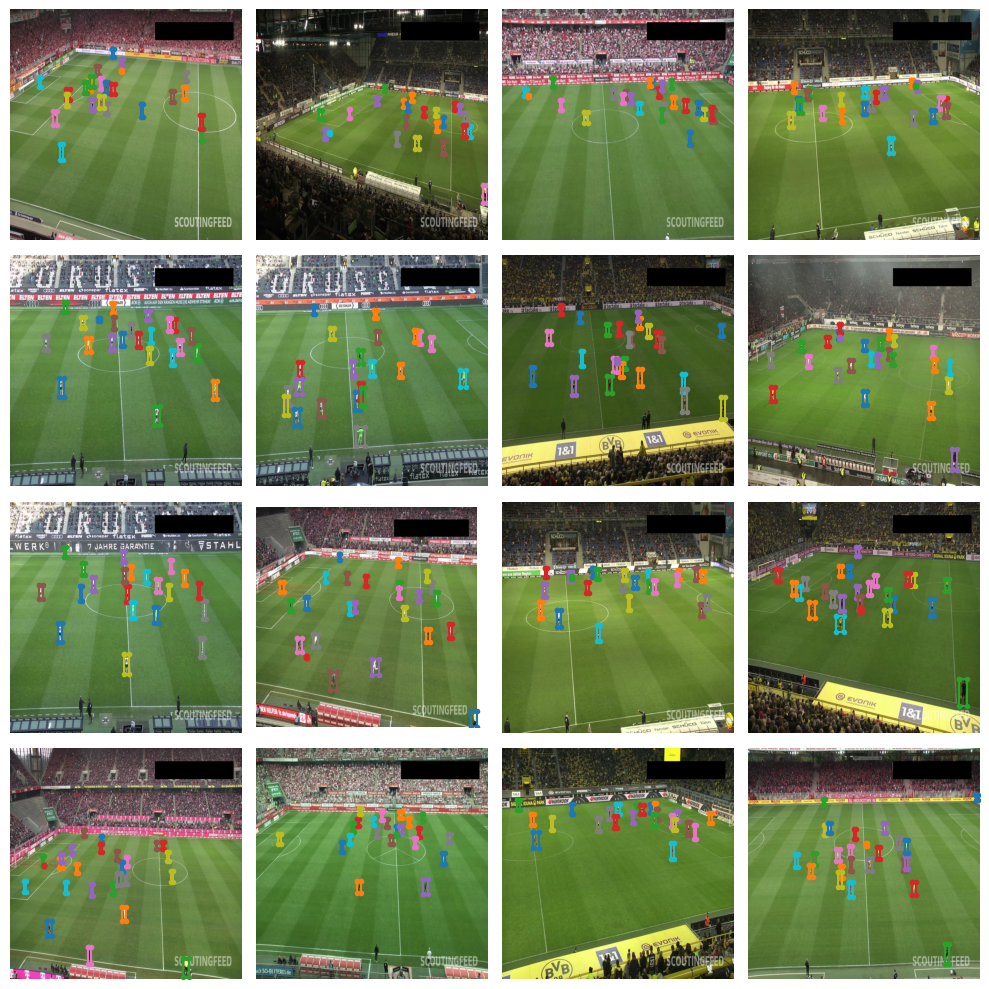

In [5]:
val_data.dataset.plot()

In [6]:
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 6e-5,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}


In [7]:
model = models.get(MODEL_ARCH, pretrained_weights="coco", num_classes=NUM_CLASES).to(DEVICE)

[2023-09-09 16:30:28] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [8]:
trainer = Trainer(experiment_name=EXPERIMENT, ckpt_root_dir=CHECKPOINT_DIR)

In [9]:
trainer.train(
    model=model, 
    training_params=train_params, 
    train_loader=train_data, 
    valid_loader=val_data
)

The console stream is now moved to ./checkpoints/FUTSTATS/console_sep09_16_30_29.txt


[2023-09-09 16:30:29] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-09 16:30:31] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 612        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         76         (len(train_loader))
    - Gradient updates per epoch:   76         (len(train_loader) / batch_accumulate)

[2023-09-09 16:31:12] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/FUTSTATS/ckpt_best.pth
[2023-09-09 16:31:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mA

In [10]:
best_model = models.get(MODEL_ARCH,
                        num_classes=NUM_CLASES,
                        checkpoint_path="/home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FUTSTATS/ckpt_best.pth")

In [11]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1, 
        top_k_predictions=300, 
        num_cls=len(dataset_params['classes']), 
        normalize_targets=True, 
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01, 
            nms_top_k=1000, 
            max_predictions=300,                                                                              
            nms_threshold=0.7
        )
    )
)

[2023-09-09 19:27:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FUTSTATS/ckpt_best.pth EMA checkpoint.
Testing:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it]

{'PPYoloELoss/loss_cls': 0.5529849,
 'PPYoloELoss/loss_iou': 0.13633531,
 'PPYoloELoss/loss_dfl': 0.5509581,
 'PPYoloELoss/loss': 1.1693022,
 'Precision@0.50': 0.4790135622024536,
 'Recall@0.50': 0.8815186619758606,
 'mAP@0.50': 0.8328012228012085,
 'F1@0.50': 0.6026214957237244}

Testing: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
